In [1]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pylab as plt
from time import sleep
%matplotlib inline

In [2]:
import gym 
from collections import namedtuple, defaultdict
import pandas as pd
import numpy as np
from gym.utils import seeding
from gym.spaces import Discrete

class ISTestEnv(gym.Env):
    def __init__(self):
        self.n_items = 10
        self.rewards = list(range(1, self.n_items+1))
        
        self.action_space = Discrete(self.n_items)
        self.observation_space = None
       
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        observation = None
        reward = self.rewards[action]
        done = None
        info = None
        return observation, reward, done, info

    def reset(self):
        observation = None
        return observation 

    
class Top2TestEnv(gym.Env):
    def __init__(self):
        self.n_items = 10
        self.rewards = np.ones(shape=(self.n_items))
        self.rewards[-1] = 10
        self.rewards[-2] = 9
        
        self.action_space = Discrete(self.n_items)
        self.observation_space = None
       
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        observation = None
        reward = self.rewards[action]
        done = None
        info = None
        return observation, reward, done, info

    def reset(self):
        observation = None
        return observation     


In [3]:
env = Top2TestEnv()
#env = ISTestEnv()
env.reset()
env.step(9)

(None, 10.0, None, None)

In [4]:
theta = np.zeros(env.action_space.n)

pi = np.exp(theta)
pi = pi / np.sum(pi)

pi

array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1])

In [5]:
def grad_pi(pi, a):
    
    grad = []
    for i in range(len(pi)):
        grad.append(int(i==a) - pi[a])
    
    return grad

def compute_rewards_to_go(rewards, gamma):
    rewards_to_go = [rewards[-1]]
    for k in range(2, len(rewards)+1):
        rewards_to_go = [rewards[-k] + gamma * rewards_to_go[0]] + rewards_to_go
    return rewards_to_go

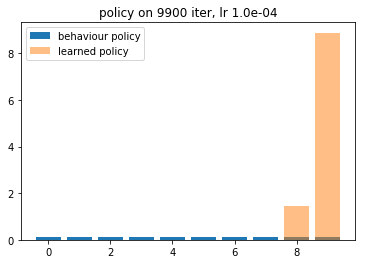

In [6]:
lr = 0.0001
N = 10000
rollout_size = 5
gamma = 0.9
theta = np.zeros(env.action_space.n)

b = np.ones_like(theta) / len(theta)
#b = [ (10-i)/55 for i in range(len(theta))]

IScorrection = True
TopKcorrection = True
K = 2

for n in range(N):
    
    actions = []
    rewards = []
    probas = []
    
    for i in range(rollout_size):
        a = np.random.choice(list(range(len(theta))), p=b)
        _, r, _, _ = env.step(a)
        
        actions.append(a)
        rewards.append(r)
        probas.append(b[a])
        
        
    pi = np.exp(theta)
    pi = pi / np.sum(pi)
     
    rewards_to_go = compute_rewards_to_go(rewards, gamma)  
    grad = np.zeros_like(theta)
    for j, a in enumerate(actions):
        delta = np.multiply(grad_pi(pi, a), rewards_to_go[j]) 
        
        if IScorrection:
            delta = delta * pi[a] / b[a]
        
        if TopKcorrection:
            lambdaK = K*(1 - pi[a])**(K-1)
            delta = delta * lambdaK
        
        grad += delta 
    
    theta = theta + lr*grad
    
    if n % 100 == 0:
        clear_output(wait=True)
        plt.clf()
        plt.bar(range(len(theta)), b, label = 'behaviour policy')
        
        plt.bar(range(len(theta)), np.exp(theta), alpha=0.5, label = 'learned policy')
        plt.title('policy on %d iter, lr %.1e' % (n, lr))
        
        plt.legend()
        plt.show();
    
    